# HW2P2: Image Recognition and Verification

## Project Overview

This is the second homework in 11785: Introduction to Deep Learning. We are trying to tackle the problem of Image Verification. For this, we will need to first train our own CNN model to tackle the problem of classification, consisting of 8631 identities. Using this, we get the face embeddings for different pairs of images and try to identify if the pair of face matches or not.


## Model Architecture

The core of this project is a **ResNet101** architecture, a deep residual network renowned for its effectiveness in image classification tasks.

## Training

The training process involves optimizing the ResNet101 model to accurately classify images into the correct identities. Key aspects of the training include:

- **Epochs**: 20
- **Batch Size**: 64
- **Learning Rate**: 0.0015
- **Data Augmentation**: Cutmix


## Results

Upon completing the training process, the model achieved the following performance metrics on the validation set:

- **Classification Accuracy**: 76.62%
- **Validation Classification Loss**: 2.6457

For the verification task, the model's performance is evaluated using several metrics:

- **Accuracy (ACC)**: 89.4%
- **Equal Error Rate (EER)**: 11.59%
- **Area Under Curve (AUC)**: 95.29%
- **True Positive Rates (TPRs)** at various False Positive Rates (FPRs):
  - TPR@FPR=1e-4: 40.53%
  - TPR@FPR=5e-4: 40.53%
  - TPR@FPR=1e-3: 40.53%
  - TPR@FPR=5e-3: 53.16%
  - TPR@FPR=5e-2: 79.84%

# Libraries

In [1]:
!nvidia-smi  # Run this to see what GPU you have

Sat Oct 19 16:11:58 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.90.07              Driver Version: 550.90.07      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-PCIE-16GB           Off |   00000000:00:04.0 Off |                    0 |
| N/A   35C    P0             29W /  250W |       0MiB /  16384MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
!pip install wandb torchsummary==1.1.0 --quiet  # Install WandB
!pip install pytorch_metric_learning --quiet  #Install the Pytorch Metric Library

In [3]:
import torch
from torchsummary import summary
import torchvision
from torchvision.transforms import v2
import torch.nn.functional as F
import os
import gc
from tqdm import tqdm
from PIL import Image
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn import metrics as mt
from scipy.optimize import brentq
from scipy.interpolate import interp1d
import glob
import wandb
import matplotlib.pyplot as plt
from pytorch_metric_learning import samplers
import csv

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Device: ", DEVICE)

Device:  cuda


In [4]:
# from google.colab import drive # Link to your drive if you are not using Colab with GCP
# drive.mount('/content/drive') # Models in this HW take a long time to get trained and make sure to save it here

# Kaggle

In [ ]:
!rm -rf /root/.kaggle

In [ ]:
!pip install --upgrade --force-reinstall --no-deps kaggle == 1.5.8
!mkdir /root/.kaggle

with open("/root/.kaggle/kaggle.json", "w+") as f:
    f.write('{"username":"seitomoyi","key":"5165f2111fd03e4eb81eea7405f4b319"}')
    # Put your kaggle username & key here

!chmod 600 /root/.kaggle/kaggle.json

In [ ]:
!cat/root/.kaggle/kaggle.json

In [ ]:
# # Reminder: Make sure you have connected your kaggle API before running this block
!mkdir '/content/data'

!kaggle competitions download -c 11785-hw-2-p-2-face-verification-fall-2024
!unzip -qo '11785-hw-2-p-2-face-verification-fall-2024.zip' -d '/content/data'

# Config

In [5]:
config = {
    'batch_size': 64,
    'lr': 0.0015,
    'epochs': 20,
    'data_dir': "/content/data/11-785-f24-hw2p2-verification/cls_data",
    'data_ver_dir': "/content/data/11-785-f24-hw2p2-verification/ver_data",
    'checkpoint_dir': "/content/drive/MyDrive",
    'val_pair_dir': "/content/data/11-785-f24-hw2p2-verification/val_pairs.txt",
    'test_pair_dir': "/content/data/11-785-f24-hw2p2-verification/test_pairs.txt"
}

In [6]:
mean = [0.5, 0.5, 0.5]
std = [0.5, 0.5, 0.5]

# Dataset

## Dataset Class for doing Image Verification

In [7]:
class ImagePairDataset(torch.utils.data.Dataset):

    def __init__(self, data_dir, csv_file, transform):
        self.data_dir = data_dir
        self.transform = transform
        self.pairs = []
        if csv_file.endswith('.csv'):
            with open(csv_file, 'r') as f:
                reader = csv.reader(f)
                for i, row in enumerate(reader):
                    if i == 0:
                        continue
                    else:
                        self.pairs.append(row)
        else:
            with open(csv_file, 'r') as f:
                for line in f.readlines():
                    self.pairs.append(line.strip().split(' '))

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):

        img_path1, img_path2, match = self.pairs[idx]
        img1 = Image.open(os.path.join(self.data_dir, img_path1))
        img2 = Image.open(os.path.join(self.data_dir, img_path2))
        return self.transform(img1), self.transform(img2), int(match)

In [8]:
class TestImagePairDataset(torch.utils.data.Dataset):

    def __init__(self, data_dir, csv_file, transform):
        self.data_dir = data_dir
        self.transform = transform
        self.pairs = []
        if csv_file.endswith('.csv'):
            with open(csv_file, 'r') as f:
                reader = csv.reader(f)
                for i, row in enumerate(reader):
                    if i == 0:
                        continue
                    else:
                        self.pairs.append(row)
        else:
            with open(csv_file, 'r') as f:
                for line in f.readlines():
                    self.pairs.append(line.strip().split(' '))

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):

        img_path1, img_path2 = self.pairs[idx]
        img1 = Image.open(os.path.join(self.data_dir, img_path1))
        img2 = Image.open(os.path.join(self.data_dir, img_path2))
        return self.transform(img1), self.transform(img2)

## Create Dataloaders for Image Recognition

In [9]:
data_dir = config['data_dir']

train_dir = os.path.join(data_dir, 'train')
val_dir = os.path.join(data_dir, 'dev')

# train transforms
train_transforms = torchvision.transforms.Compose([
    v2.RandomPerspective(distortion_scale=0.4, p=0.3),
    torchvision.transforms.RandomRotation(15),
    torchvision.transforms.Resize(112),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=mean,
                                     std=std)])

# val transforms
val_transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize(112),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=mean,
                                     std=std)])

# get datasets
train_dataset = torchvision.datasets.ImageFolder(train_dir, transform=train_transforms)
val_dataset = torchvision.datasets.ImageFolder(val_dir, transform=val_transforms)

train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size=config["batch_size"],
                                           shuffle=True,
                                           pin_memory=True,
                                           num_workers=8,
                                           sampler=None)
val_loader = torch.utils.data.DataLoader(val_dataset,
                                         batch_size=config["batch_size"],
                                         shuffle=False,
                                         num_workers=4)

/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [10]:
data_dir = config['data_ver_dir']

# get datasets

pair_dataset = ImagePairDataset(data_dir, csv_file=config['val_pair_dir'], transform=val_transforms)
pair_dataloader = torch.utils.data.DataLoader(pair_dataset,
                                              batch_size=config["batch_size"],
                                              shuffle=False,
                                              pin_memory=True,
                                              num_workers=4)

test_pair_dataset = TestImagePairDataset(data_dir, csv_file=config['test_pair_dir'], transform=val_transforms)
test_pair_dataloader = torch.utils.data.DataLoader(test_pair_dataset,
                                                   batch_size=config["batch_size"],
                                                   shuffle=False,
                                                   pin_memory=True,
                                                   num_workers=4)

# EDA and Viz

In [11]:
# Double-check your dataset/dataloaders work as expected

print("Number of classes    : ", len(train_dataset.classes))
print("No. of train images  : ", train_dataset.__len__())
print("Shape of image       : ", train_dataset[0][0].shape)
print("Batch size           : ", config['batch_size'])
print("Train batches        : ", train_loader.__len__())
print("Val batches          : ", val_loader.__len__())

# Feel free to print more things if needed

Number of classes    :  8631
No. of train images  :  431550
Shape of image       :  torch.Size([3, 112, 112])
Batch size           :  64
Train batches        :  6743
Val batches          :  675


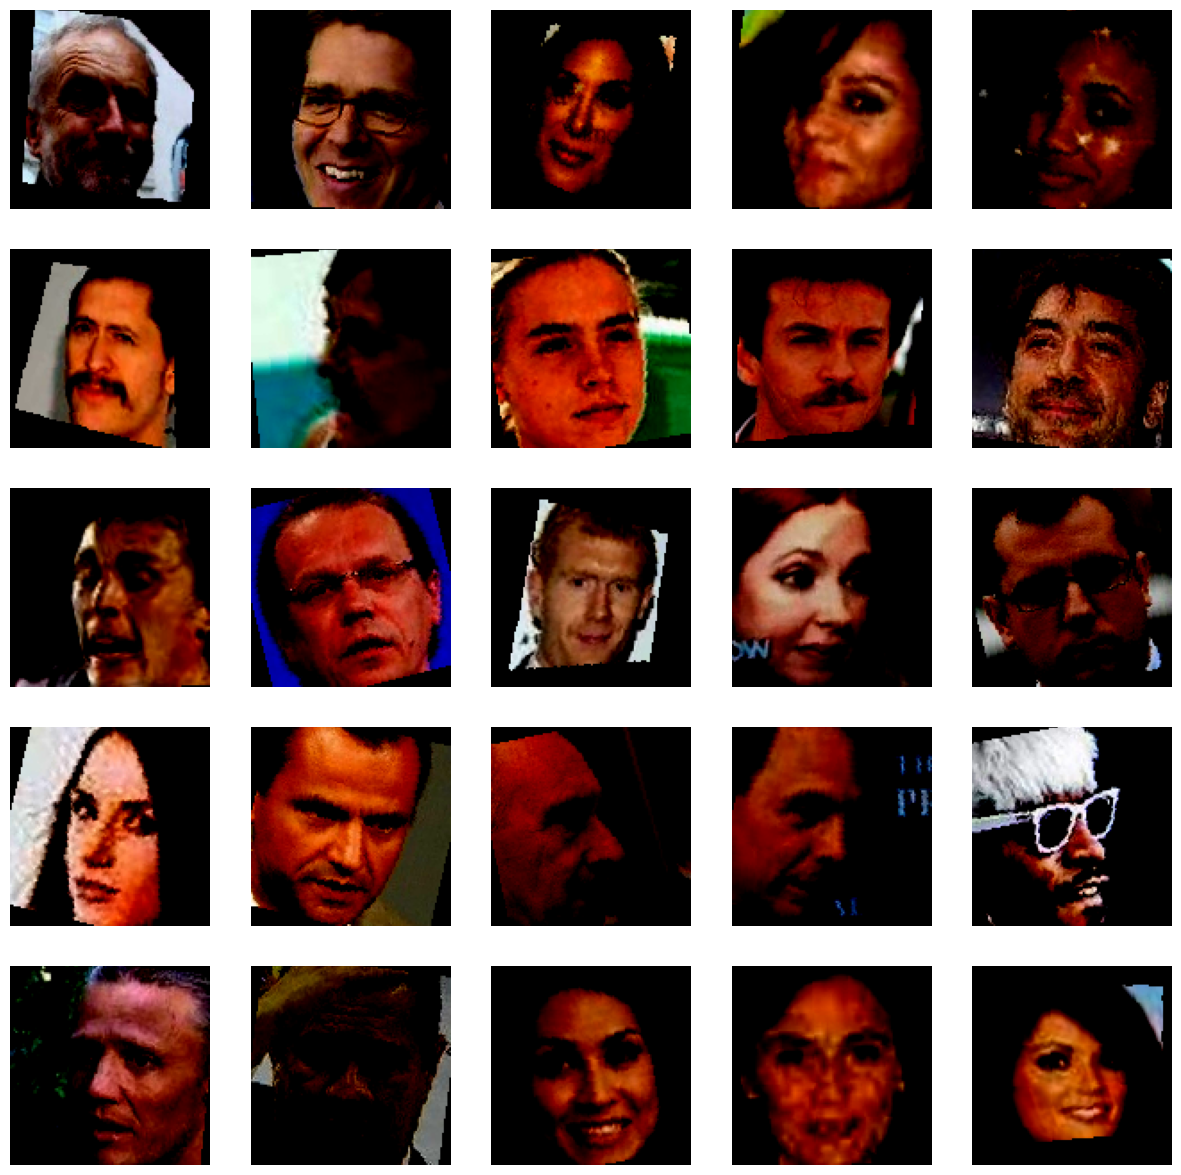

In [12]:
# Visualize a few images in the dataset

"""
You can write your own code, and you don't need to understand the code
It is highly recommended that you visualize your data augmentation as sanity check
"""

r, c = [5, 5]
fig, ax = plt.subplots(r, c, figsize=(15, 15))

k = 0
dtl = torch.utils.data.DataLoader(
    dataset=torchvision.datasets.ImageFolder(train_dir, transform=train_transforms),
    # dont wanna see the images with transforms
    batch_size=config['batch_size'],
    shuffle=True)

for data in dtl:
    x, y = data

    for i in range(r):
        for j in range(c):
            img = x[k].numpy().transpose(1, 2, 0)
            ax[i, j].imshow(img)
            ax[i, j].axis('off')
            k += 1
    break

del dtl

# Model Architecture

FAQ:

**What's a very low early deadline architecture (mandatory early submission)**?

- The very low early deadline architecture is a 5-layer CNN.
- The first convolutional layer has 64 channels, kernel size 7, and stride 4. The next three have 128, 256, 512 and 1024 channels. Each have kernel size 3 and stride 2. Documentation to make convolutional layers: https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html
- Think about strided convolutions from the lecture, as convolutions with stride = 1 and downsampling. For strided convolution, what padding do you need for preserving the spatial resolution? (Hint => padding = kernel_size // 2) - Think why?
- Each convolutional layer is accompanied by a Batchnorm and ReLU layer.
- Finally, you want to average pool over the spatial dimensions to reduce them to 1 x 1. Use AdaptiveAvgPool2d. Documentation for AdaptiveAvgPool2d: https://pytorch.org/docs/stable/generated/torch.nn.AdaptiveAvgPool2d.html
- Then, remove (Flatten?) these trivial 1x1 dimensions away.
Look through https://pytorch.org/docs/stable/nn.html


**Why does a very simple network have 4 convolutions**?

Input images are 112x112. Note that each of these convolutions downsample. Downsampling 2x effectively doubles the receptive field, increasing the spatial region each pixel extracts features from. Downsampling 32x is standard for most image models.

**Why does a very simple network have high channel sizes**?

Every time you downsample 2x, you do 4x less computation (at same channel size). To maintain the same level of computation, you 2x increase # of channels, which increases computation by 4x. So, balances out to same computation. Another intuition is - as you downsample, you lose spatial information. We want to preserve some of it in the channel dimension.

**What is return_feats?**

It essentially returns the second-to-last-layer features of a given image. It's a "feature encoding" of the input image, and you can use it for the verification task. You would use the outputs of the final classification layer for the classification task. You might also find that the classification outputs are sometimes better for verification too - try both.

In [13]:
# Define the Bottleneck block
class Bottleneck(torch.nn.Module):
    def __init__(self, input_channels, mid_channels, output_channels, use_1x1conv=False, strides=1):
        super().__init__()
        self.conv1 = torch.nn.Conv2d(input_channels, mid_channels, kernel_size=1, stride=strides)
        self.bn1 = torch.nn.BatchNorm2d(mid_channels)

        self.conv2 = torch.nn.Conv2d(mid_channels, mid_channels, kernel_size=3, padding=1)
        self.bn2 = torch.nn.BatchNorm2d(mid_channels)

        self.conv3 = torch.nn.Conv2d(mid_channels, output_channels, kernel_size=1)
        self.bn3 = torch.nn.BatchNorm2d(output_channels)

        if use_1x1conv:
            self.conv4 = torch.nn.Conv2d(input_channels, output_channels, kernel_size=1, stride=strides)
            self.bn4 = torch.nn.BatchNorm2d(output_channels)
        else:
            self.conv4 = None

    def forward(self, X):
        Y = F.relu(self.bn1(self.conv1(X)))
        Y = F.relu(self.bn2(self.conv2(Y)))
        Y = self.bn3(self.conv3(Y))
        if self.conv4:
            X = self.bn4(self.conv4(X))
        Y += X
        return F.relu(Y)

# Initial convolutional block
b1 = torch.nn.Sequential(
    torch.nn.Conv2d(3, 256, kernel_size=7, stride=2, padding=3),
    torch.nn.BatchNorm2d(256),
    torch.nn.ReLU(),
    torch.nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
)

# Function to create a ResNet block with a specified number of bottleneck layers
def resnet_block(input_channels, mid_channels, output_channels, num_blocks, first_block=False):
    blk = []
    for i in range(num_blocks):
        if i == 0 and not first_block:
            blk.append(Bottleneck(input_channels, mid_channels, output_channels, use_1x1conv=True, strides=2))
        else:
            blk.append(Bottleneck(output_channels, mid_channels, output_channels))
    return blk

# Define ResNet101 blocks
b2 = torch.nn.Sequential(*resnet_block(64, 64, 256, num_blocks=3, first_block=True))
b3 = torch.nn.Sequential(*resnet_block(256, 128, 512, num_blocks=4))   # Changed from 8 to 4
b4 = torch.nn.Sequential(*resnet_block(512, 256, 1024, num_blocks=23))  # Changed from 36 to 23
b5 = torch.nn.Sequential(*resnet_block(1024, 512, 2048, num_blocks=3))

# Define the ResNet101 model
class ResNet101(torch.nn.Module):
    def __init__(self, num_classes=8631):
        super().__init__()
        self.backbone = torch.nn.Sequential(
            b1, b2, b3, b4, b5,
            torch.nn.AdaptiveAvgPool2d((1, 1)),
            torch.nn.Flatten()
        )
        self.fc = torch.nn.Linear(2048, num_classes)

    def forward(self, x):
        feats = self.backbone(x)
        out = self.fc(feats)
        return {"feats": feats, "out": out}

# Instantiate and move the model to the desired device
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ResNet101(num_classes=8631).to(DEVICE)

# Display the model summary
summary(model, (3, 112, 112))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 256, 56, 56]           37888
       BatchNorm2d-2          [-1, 256, 56, 56]             512
              ReLU-3          [-1, 256, 56, 56]               0
         MaxPool2d-4          [-1, 256, 28, 28]               0
            Conv2d-5           [-1, 64, 28, 28]           16448
       BatchNorm2d-6           [-1, 64, 28, 28]             128
            Conv2d-7           [-1, 64, 28, 28]           36928
       BatchNorm2d-8           [-1, 64, 28, 28]             128
            Conv2d-9          [-1, 256, 28, 28]           16640
      BatchNorm2d-10          [-1, 256, 28, 28]             512
       Bottleneck-11          [-1, 256, 28, 28]               0
           Conv2d-12           [-1, 64, 28, 28]           16448
      BatchNorm2d-13           [-1, 64, 28, 28]             128
           Conv2d-14           [-1, 64,

# Metrics

In [14]:
class AverageMeter:
    """Computes and stores the average and current value"""

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [15]:
def accuracy(output, target, topk=(1,)):
    """Computes the accuracy over the k top predictions for the specified values of k"""
    maxk = min(max(topk), output.size()[1])
    batch_size = target.size(0)
    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.reshape(1, -1).expand_as(pred))
    return [correct[:min(k, maxk)].reshape(-1).float().sum(0) * 100. / batch_size for k in topk]

In [16]:
# Defining Loss function
criterion = torch.nn.CrossEntropyLoss(label_smoothing=0.1)

# Defining Optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=config['lr'], weight_decay=1e-4)

# Defining Scheduler
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=60)

# Initialising mixed-precision training. # Good news. We've already implemented FP16 (Mixed precision training) for you
# It is useful only in the case of compatible GPUs such as T4/V100
scaler = torch.cuda.amp.GradScaler()

/tmp/ipykernel_23/2388295627.py:12: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


In [17]:
def get_ver_metrics(labels, scores, FPRs):
    # eer and auc
    fpr, tpr, _ = mt.roc_curve(labels, scores, pos_label=1)
    roc_curve = interp1d(fpr, tpr)
    EER = 100. * brentq(lambda x: 1. - x - roc_curve(x), 0., 1.)
    AUC = 100. * mt.auc(fpr, tpr)

    # get acc
    tnr = 1. - fpr
    pos_num = labels.count(1)
    neg_num = labels.count(0)
    ACC = 100. * max(tpr * pos_num + tnr * neg_num) / len(labels)

    # TPR @ FPR
    if isinstance(FPRs, list):
        TPRs = [
            ('TPR@FPR={}'.format(FPR), 100. * roc_curve(float(FPR)))
            for FPR in FPRs
        ]
    else:
        TPRs = []

    return {
        'ACC': ACC,
        'EER': EER,
        'AUC': AUC,
        'TPRs': TPRs,
    }

# Train and Validation Function

In [18]:
@torch.no_grad()
def valid_epoch_cls(model, dataloader, device, config):
    model.eval()
    batch_bar = tqdm(total=len(dataloader), dynamic_ncols=True, position=0, leave=False, desc='Val Cls.', ncols=5)

    # metric meters
    loss_m = AverageMeter()
    acc_m = AverageMeter()

    for i, (images, labels) in enumerate(dataloader):
        # Move images to device
        images, labels = images.to(device), labels.to(device)

        # Get model outputs
        with torch.inference_mode():
            outputs = model(images)
            loss = criterion(outputs['out'], labels)

        # metrics
        acc = accuracy(outputs['out'], labels)[0].item()
        loss_m.update(loss.item())
        acc_m.update(acc)

        batch_bar.set_postfix(
            acc="{:.04f}% ({:.04f})".format(acc, acc_m.avg),
            loss="{:.04f} ({:.04f})".format(loss.item(), loss_m.avg))

        batch_bar.update()

    batch_bar.close()
    return acc_m.avg, loss_m.avg

In [19]:
def train_epoch(model, dataloader, optimizer, lr_scheduler, scaler, device, config):
    model.train()

    # metric meters
    loss_m = AverageMeter()
    acc_m = AverageMeter()

    # Progress Bar
    batch_bar = tqdm(total=len(dataloader), dynamic_ncols=True, leave=False, position=0, desc='Train', ncols=5)

    mixup = v2.CutMix(num_classes=8631, alpha=1.0)

    for i, (images, labels) in enumerate(dataloader):

        optimizer.zero_grad()  # Zero gradients

        # send to cuda
        images = images.to(device, non_blocking=True)
        if isinstance(labels, (tuple, list)):
            targets1, targets2, lam = labels
            labels = (targets1.to(device), targets2.to(device), lam)
        else:
            labels = labels.to(device, non_blocking=True)


        mixed_images, mixed_labels = mixup(images, labels)
        outputs = model(mixed_images)
        loss = criterion(outputs['out'], mixed_labels)
    

        scaler.scale(loss).backward()  # This is a replacement for loss.backward()
        scaler.step(optimizer)  # This is a replacement for optimizer.step()
        scaler.update()
        # metrics
        loss_m.update(loss.item())
        if 'feats' in outputs:
            acc = accuracy(outputs['out'], labels)[0].item()
        else:
            acc = 0.0
        acc_m.update(acc)

        # tqdm lets you add some details so you can monitor training as you train.
        batch_bar.set_postfix(
            # acc         = "{:.04f}%".format(100*accuracy),
            acc="{:.04f}% ({:.04f})".format(acc, acc_m.avg),
            loss="{:.04f} ({:.04f})".format(loss.item(), loss_m.avg),
            lr="{:.04f}".format(float(optimizer.param_groups[0]['lr'])))

        batch_bar.update()  # Update tqdm bar

    # You may want to call some schedulers inside the train function. What are these?
    if lr_scheduler is not None:
        lr_scheduler.step()

    batch_bar.close()

    return acc_m.avg, loss_m.avg

In [20]:
gc.collect()  # These commands help you when you face CUDA OOM error
torch.cuda.empty_cache()

# Verification Task

In [21]:
def valid_epoch_ver(model, pair_data_loader, device, config):
    model.eval()
    scores = []
    match_labels = []
    batch_bar = tqdm(total=len(pair_data_loader), dynamic_ncols=True, position=0, leave=False, desc='Val Veri.')
    for i, (images1, images2, labels) in enumerate(pair_data_loader):
        # match_labels = match_labels.to(device)
        images = torch.cat([images1, images2], dim=0).to(device)
        # Get model outputs
        with torch.inference_mode():
            outputs = model(images)

        feats = F.normalize(outputs['feats'], dim=1)
        feats1, feats2 = feats.chunk(2)
        similarity = F.cosine_similarity(feats1, feats2)
        scores.append(similarity.cpu().numpy())
        match_labels.append(labels.cpu().numpy())
        batch_bar.update()

    scores = np.concatenate(scores)
    match_labels = np.concatenate(match_labels)

    FPRs = ['1e-4', '5e-4', '1e-3', '5e-3', '5e-2']
    metric_dict = get_ver_metrics(match_labels.tolist(), scores.tolist(), FPRs)
    print(metric_dict)

    return metric_dict['ACC']

# WandB

In [22]:
wandb.login(key="98642f33baa53793f08e5f32f1d09da8c7c6e80b")

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [23]:
# Create your wandb run
run = wandb.init(
    # name="early-submission",
    reinit=True,
    # run_id = ### Insert specific run id here if you want to resume a previous run
    # resume = "must" ### You need this to resume previous runs, but comment out reinit = True when using this
    project="hw2p2",
    config=config
)

wandb: Currently logged in as: seitomoyi (seitomoyi-carnegie-mellon-university). Use `wandb login --relogin` to force relogin
wandb: Tracking run with wandb version 0.18.3
wandb: Run data is saved locally in /kaggle/working/wandb/run-20241019_161516-xxb0fskr
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run spring-armadillo-37
wandb: ⭐️ View project at https://wandb.ai/seitomoyi-carnegie-mellon-university/hw2p2
wandb: 🚀 View run at https://wandb.ai/seitomoyi-carnegie-mellon-university/hw2p2/runs/xxb0fskr


# Checkpointing and Loading Model

In [24]:
# Uncomment the line for saving the scheduler save dict if you are using a scheduler
def save_model(model, optimizer, scheduler, metrics, epoch, path):
    torch.save(
        {'model_state_dict': model.state_dict(),
         'optimizer_state_dict': optimizer.state_dict(),
         'scheduler_state_dict': scheduler.state_dict(),
         'metric': metrics,
         'epoch': epoch},
        path)


def load_model(model, optimizer=None, scheduler=None, path='./checkpoint.pth'):
    checkpoint = torch.load(path)
    model.load_state_dict(checkpoint['model_state_dict'])
    if optimizer is not None:
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    else:
        optimizer = None
    if scheduler is not None:
        scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
    else:
        scheduler = None
    epoch = checkpoint['epoch']
    metrics = checkpoint['metric']
    return model, optimizer, scheduler, epoch, metrics

# Experiments

In [25]:
best_valid_cls_acc = 0.0
eval_cls = True
best_valid_ret_acc = 0.0
for epoch in range(0, config['epochs']):
    # epoch
    print("\nEpoch {}/{}".format(epoch + 1, config['epochs']))

    # train
    train_cls_acc, train_loss = train_epoch(model, train_loader, optimizer, scheduler, scaler, DEVICE, config)
    curr_lr = float(optimizer.param_groups[0]['lr'])
    print("\nEpoch {}/{}: \nTrain Cls. Acc {:.04f}%\t Train Cls. Loss {:.04f}\t Learning Rate {:.04f}".format(epoch + 1,
                                                                                                              config[
                                                                                                                  'epochs'],
                                                                                                              train_cls_acc,
                                                                                                              train_loss,
                                                                                                              curr_lr))
    metrics = {
        'train_cls_acc': train_cls_acc,
        'train_loss': train_loss,
    }
    # classification validation
    if eval_cls:
        valid_cls_acc, valid_loss = valid_epoch_cls(model, val_loader, DEVICE, config)
        print("Val Cls. Acc {:.04f}%\t Val Cls. Loss {:.04f}".format(valid_cls_acc, valid_loss))
        metrics.update({
            'valid_cls_acc': valid_cls_acc,
            'valid_loss': valid_loss,
        })

    # retrieval validation
    valid_ret_acc = valid_epoch_ver(model, pair_dataloader, DEVICE, config)
    print("Val Ret. Acc {:.04f}%".format(valid_ret_acc))
    metrics.update({
        'valid_ret_acc': valid_ret_acc
    })

    # save model
    save_model(model, optimizer, scheduler, metrics, epoch, os.path.join(config['checkpoint_dir'], 'last.pth'))
    print("Saved epoch model")

    # save best model
    if eval_cls:
        if valid_cls_acc >= best_valid_cls_acc:
            best_valid_cls_acc = valid_cls_acc
            save_model(model, optimizer, scheduler, metrics, epoch,
                       os.path.join(config['checkpoint_dir'], 'best_cls.pth'))
            wandb.save(os.path.join(config['checkpoint_dir'], 'best_cls.pth'))
            print("Saved best classification model")

    if valid_ret_acc >= best_valid_ret_acc:
        best_valid_ret_acc = valid_ret_acc
        save_model(model, optimizer, scheduler, metrics, epoch, os.path.join(config['checkpoint_dir'], 'best_ret.pth'))
        wandb.save(os.path.join(config['checkpoint_dir'], 'best_ret.pth'))
        print("Saved best retrieval model")

    # log to tracker
    if run is not None:
        run.log(metrics)


Epoch 1/20



Epoch 1/20: 
Train Cls. Acc 0.0065%	 Train Cls. Loss 9.0840	 Learning Rate 0.0015


Val Cls. Acc 0.0116%	 Val Cls. Loss 9.0650


{'ACC': 51.6, 'EER': 50.147351755529456, 'AUC': 49.768925131742684, 'TPRs': [('TPR@FPR=1e-4', 0.009070773930753565), ('TPR@FPR=5e-4', 0.04535386965376782), ('TPR@FPR=1e-3', 0.09070773930753565), ('TPR@FPR=5e-3', 0.45353869653767825), ('TPR@FPR=5e-2', 5.295315682281059)]}
Val Ret. Acc 51.6000%
Saved epoch model


wandb: WARNING Saving files without folders. If you want to preserve subdirectories pass base_path to wandb.save, i.e. wandb.save("/mnt/folder/file.h5", base_path="/mnt")


Saved best classification model
Saved best retrieval model

Epoch 2/20


Train:   0%|          | 0/6743 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(



Epoch 2/20: 
Train Cls. Acc 0.0081%	 Train Cls. Loss 9.0649	 Learning Rate 0.0015


Val Cls. Acc 0.0208%	 Val Cls. Loss 8.9920


{'ACC': 56.6, 'EER': 43.61493123775787, 'AUC': 57.28956181802904, 'TPRs': [('TPR@FPR=1e-4', 0.020042090970807874), ('TPR@FPR=5e-4', 0.10021045485403936), ('TPR@FPR=1e-3', 0.20042090970807871), ('TPR@FPR=5e-3', 1.0021045485403937), ('TPR@FPR=5e-2', 8.010437881873727)]}
Val Ret. Acc 56.6000%
Saved epoch model
Saved best classification model
Saved best retrieval model

Epoch 3/20


Train:   0%|          | 0/6743 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(



Epoch 3/20: 
Train Cls. Acc 0.0204%	 Train Cls. Loss 8.9660	 Learning Rate 0.0015


Val Cls. Acc 0.0671%	 Val Cls. Loss 8.6114


{'ACC': 64.3, 'EER': 35.756385068728875, 'AUC': 68.56581532416503, 'TPRs': [('TPR@FPR=1e-4', 0.20366598778004072), ('TPR@FPR=5e-4', 0.20366598778004072), ('TPR@FPR=1e-3', 0.20366598778004072), ('TPR@FPR=5e-3', 2.4439918533604885), ('TPR@FPR=5e-2', 15.274949083503056)]}
Val Ret. Acc 64.3000%
Saved epoch model
Saved best classification model
Saved best retrieval model

Epoch 4/20


Train:   0%|          | 0/6743 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(



Epoch 4/20: 
Train Cls. Acc 0.0911%	 Train Cls. Loss 8.6687	 Learning Rate 0.0015


Val Cls. Acc 0.4259%	 Val Cls. Loss 7.9615


{'ACC': 66.2, 'EER': 34.38113948907594, 'AUC': 71.5875943805793, 'TPRs': [('TPR@FPR=1e-4', 4.0733197556008145), ('TPR@FPR=5e-4', 4.0733197556008145), ('TPR@FPR=1e-3', 4.0733197556008145), ('TPR@FPR=5e-3', 4.480651731160896), ('TPR@FPR=5e-2', 19.144602851323828)]}
Val Ret. Acc 66.2000%
Saved epoch model
Saved best classification model
Saved best retrieval model

Epoch 5/20


Train:   0%|          | 0/6743 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(



Epoch 5/20: 
Train Cls. Acc 0.5534%	 Train Cls. Loss 8.2896	 Learning Rate 0.0015


Val Cls. Acc 2.9884%	 Val Cls. Loss 7.0413


{'ACC': 75.0, 'EER': 26.680244399185337, 'AUC': 82.64117574094007, 'TPRs': [('TPR@FPR=1e-4', 11.608961303462321), ('TPR@FPR=5e-4', 11.608961303462321), ('TPR@FPR=1e-3', 11.608961303462321), ('TPR@FPR=5e-3', 16.700610997963338), ('TPR@FPR=5e-2', 39.71486761710794)]}
Val Ret. Acc 75.0000%
Saved epoch model
Saved best classification model
Saved best retrieval model

Epoch 6/20


Train:   0%|          | 0/6743 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(



Epoch 6/20: 
Train Cls. Acc 2.0086%	 Train Cls. Loss 7.8809	 Learning Rate 0.0015


Val Cls. Acc 8.5833%	 Val Cls. Loss 6.3698


{'ACC': 80.8, 'EER': 19.64636542232878, 'AUC': 88.6015068882318, 'TPRs': [('TPR@FPR=1e-4', 9.775967413441954), ('TPR@FPR=5e-4', 9.775967413441954), ('TPR@FPR=1e-3', 9.775967413441954), ('TPR@FPR=5e-3', 27.698574338085542), ('TPR@FPR=5e-2', 55.193482688391036)]}
Val Ret. Acc 80.8000%
Saved epoch model
Saved best classification model
Saved best retrieval model

Epoch 7/20


Train:   0%|          | 0/6743 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(



Epoch 7/20: 
Train Cls. Acc 4.8453%	 Train Cls. Loss 7.4751	 Learning Rate 0.0015


Val Cls. Acc 16.4117%	 Val Cls. Loss 5.7415


{'ACC': 81.6, 'EER': 18.53360488798298, 'AUC': 90.25004101328831, 'TPRs': [('TPR@FPR=1e-4', 21.384928716904277), ('TPR@FPR=5e-4', 21.384928716904277), ('TPR@FPR=1e-3', 21.384928716904277), ('TPR@FPR=5e-3', 32.9938900203666), ('TPR@FPR=5e-2', 59.063136456211815)]}
Val Ret. Acc 81.6000%
Saved epoch model
Saved best classification model
Saved best retrieval model

Epoch 8/20


Train:   0%|          | 0/6743 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(



Epoch 8/20: 
Train Cls. Acc 8.2898%	 Train Cls. Loss 7.1282	 Learning Rate 0.0014


Val Cls. Acc 25.5257%	 Val Cls. Loss 5.1400


{'ACC': 83.1, 'EER': 17.311608961317084, 'AUC': 91.19194619056574, 'TPRs': [('TPR@FPR=1e-4', 20.162932790224033), ('TPR@FPR=5e-4', 20.162932790224033), ('TPR@FPR=1e-3', 20.162932790224033), ('TPR@FPR=5e-3', 33.604887983706725), ('TPR@FPR=5e-2', 66.19144602851324)]}
Val Ret. Acc 83.1000%
Saved epoch model
Saved best classification model
Saved best retrieval model

Epoch 9/20


Train:   0%|          | 0/6743 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(



Epoch 9/20: 
Train Cls. Acc 12.5424%	 Train Cls. Loss 6.7929	 Learning Rate 0.0014


Val Cls. Acc 35.9539%	 Val Cls. Loss 4.5696


{'ACC': 86.2, 'EER': 13.948919449922162, 'AUC': 92.66002184707845, 'TPRs': [('TPR@FPR=1e-4', 18.329938900203665), ('TPR@FPR=5e-4', 18.329938900203665), ('TPR@FPR=1e-3', 18.329938900203665), ('TPR@FPR=5e-3', 37.270875763747455), ('TPR@FPR=5e-2', 65.78411405295316)]}
Val Ret. Acc 86.2000%
Saved epoch model
Saved best classification model
Saved best retrieval model

Epoch 10/20


Train:   0%|          | 0/6743 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(



Epoch 10/20: 
Train Cls. Acc 16.9830%	 Train Cls. Loss 6.4827	 Learning Rate 0.0014


Val Cls. Acc 43.6050%	 Val Cls. Loss 4.1432


{'ACC': 85.7, 'EER': 14.341846758377011, 'AUC': 92.7040361076989, 'TPRs': [('TPR@FPR=1e-4', 31.364562118126273), ('TPR@FPR=5e-4', 31.364562118126273), ('TPR@FPR=1e-3', 31.364562118126273), ('TPR@FPR=5e-3', 38.289205702647656), ('TPR@FPR=5e-2', 71.4867617107943)]}
Val Ret. Acc 85.7000%
Saved epoch model
Saved best classification model

Epoch 11/20


Train:   0%|          | 0/6743 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(



Epoch 11/20: 
Train Cls. Acc 21.4373%	 Train Cls. Loss 6.1936	 Learning Rate 0.0014


Val Cls. Acc 49.0807%	 Val Cls. Loss 3.9395


{'ACC': 86.7, 'EER': 13.752455795732372, 'AUC': 93.53070394807916, 'TPRs': [('TPR@FPR=1e-4', 35.84521384928717), ('TPR@FPR=5e-4', 35.84521384928717), ('TPR@FPR=1e-3', 35.84521384928717), ('TPR@FPR=5e-3', 40.32586558044807), ('TPR@FPR=5e-2', 69.24643584521385)]}
Val Ret. Acc 86.7000%
Saved epoch model
Saved best classification model
Saved best retrieval model

Epoch 12/20


Train:   0%|          | 0/6743 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(



Epoch 12/20: 
Train Cls. Acc 25.6208%	 Train Cls. Loss 5.9373	 Learning Rate 0.0014


Val Cls. Acc 55.8187%	 Val Cls. Loss 3.6747


{'ACC': 87.2, 'EER': 13.034623217919098, 'AUC': 94.11889452182507, 'TPRs': [('TPR@FPR=1e-4', 25.45824847250509), ('TPR@FPR=5e-4', 25.45824847250509), ('TPR@FPR=1e-3', 25.45824847250509), ('TPR@FPR=5e-3', 35.84521384928717), ('TPR@FPR=5e-2', 72.09775967413442)]}
Val Ret. Acc 87.2000%


Saved epoch model
Saved best classification model
Saved best retrieval model

Epoch 13/20


Train:   0%|          | 0/6743 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(



Epoch 13/20: 
Train Cls. Acc 28.7377%	 Train Cls. Loss 5.7295	 Learning Rate 0.0013


Val Cls. Acc 60.6975%	 Val Cls. Loss 3.3847


{'ACC': 86.9, 'EER': 13.16306483294801, 'AUC': 93.48748994674274, 'TPRs': [('TPR@FPR=1e-4', 29.531568228105908), ('TPR@FPR=5e-4', 29.531568228105908), ('TPR@FPR=1e-3', 29.531568228105908), ('TPR@FPR=5e-3', 34.623217922606926), ('TPR@FPR=5e-2', 72.09775967413442)]}
Val Ret. Acc 86.9000%
Saved epoch model
Saved best classification model

Epoch 14/20


Train:   0%|          | 0/6743 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(



Epoch 14/20: 
Train Cls. Acc 32.0300%	 Train Cls. Loss 5.5232	 Learning Rate 0.0013


Val Cls. Acc 64.5331%	 Val Cls. Loss 3.1949


{'ACC': 87.3, 'EER': 12.966601178605904, 'AUC': 94.05847494588247, 'TPRs': [('TPR@FPR=1e-4', 16.4969450101833), ('TPR@FPR=5e-4', 16.4969450101833), ('TPR@FPR=1e-3', 16.4969450101833), ('TPR@FPR=5e-3', 43.17718940936864), ('TPR@FPR=5e-2', 75.96741344195519)]}
Val Ret. Acc 87.3000%
Saved epoch model
Saved best classification model
Saved best retrieval model

Epoch 15/20


Train:   0%|          | 0/6743 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(



Epoch 15/20: 
Train Cls. Acc 35.0343%	 Train Cls. Loss 5.3534	 Learning Rate 0.0013


Val Cls. Acc 67.8960%	 Val Cls. Loss 3.0685


{'ACC': 89.2, 'EER': 11.198428290741253, 'AUC': 94.95476534397147, 'TPRs': [('TPR@FPR=1e-4', 38.085539714867615), ('TPR@FPR=5e-4', 38.085539714867615), ('TPR@FPR=1e-3', 38.085539714867615), ('TPR@FPR=5e-3', 45.41751527494908), ('TPR@FPR=5e-2', 73.5234215885947)]}
Val Ret. Acc 89.2000%
Saved epoch model
Saved best classification model
Saved best retrieval model

Epoch 16/20


Train:   0%|          | 0/6743 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(



Epoch 16/20: 
Train Cls. Acc 37.3269%	 Train Cls. Loss 5.2221	 Learning Rate 0.0013


Val Cls. Acc 69.5403%	 Val Cls. Loss 2.9671


{'ACC': 88.3, 'EER': 12.180746561835484, 'AUC': 94.87193850807661, 'TPRs': [('TPR@FPR=1e-4', 35.84521384928717), ('TPR@FPR=5e-4', 35.84521384928717), ('TPR@FPR=1e-3', 35.84521384928717), ('TPR@FPR=5e-3', 47.45417515274949), ('TPR@FPR=5e-2', 77.18940936863544)]}
Val Ret. Acc 88.3000%
Saved epoch model
Saved best classification model

Epoch 17/20


Train:   0%|          | 0/6743 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(



Epoch 17/20: 
Train Cls. Acc 39.0844%	 Train Cls. Loss 5.1349	 Learning Rate 0.0012


Val Cls. Acc 73.4578%	 Val Cls. Loss 2.7701


{'ACC': 89.5, 'EER': 11.201629327902934, 'AUC': 95.54215565843333, 'TPRs': [('TPR@FPR=1e-4', 42.15885947046843), ('TPR@FPR=5e-4', 42.15885947046843), ('TPR@FPR=1e-3', 42.15885947046843), ('TPR@FPR=5e-3', 54.378818737270876), ('TPR@FPR=5e-2', 82.4847250509165)]}
Val Ret. Acc 89.5000%
Saved epoch model
Saved best classification model
Saved best retrieval model

Epoch 18/20


Train:   0%|          | 0/6743 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(



Epoch 18/20: 
Train Cls. Acc 41.3523%	 Train Cls. Loss 4.9766	 Learning Rate 0.0012


Val Cls. Acc 74.5340%	 Val Cls. Loss 2.6946


{'ACC': 89.9, 'EER': 10.997963340167285, 'AUC': 95.80624122215599, 'TPRs': [('TPR@FPR=1e-4', 38.69653767820774), ('TPR@FPR=5e-4', 38.69653767820774), ('TPR@FPR=1e-3', 38.69653767820774), ('TPR@FPR=5e-3', 58.65580448065173), ('TPR@FPR=5e-2', 81.67006109979633)]}
Val Ret. Acc 89.9000%
Saved epoch model
Saved best classification model
Saved best retrieval model

Epoch 19/20


Train:   0%|          | 0/6743 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(



Epoch 19/20: 
Train Cls. Acc 42.8310%	 Train Cls. Loss 4.8771	 Learning Rate 0.0012


Val Cls. Acc 74.5973%	 Val Cls. Loss 2.7600


{'ACC': 89.4, 'EER': 10.997963340117424, 'AUC': 95.48493711962675, 'TPRs': [('TPR@FPR=1e-4', 43.17718940936864), ('TPR@FPR=5e-4', 43.17718940936864), ('TPR@FPR=1e-3', 43.17718940936864), ('TPR@FPR=5e-3', 48.87983706720978), ('TPR@FPR=5e-2', 79.63340122199592)]}
Val Ret. Acc 89.4000%
Saved epoch model
Saved best classification model

Epoch 20/20


Train:   0%|          | 0/6743 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(



Epoch 20/20: 
Train Cls. Acc 44.6376%	 Train Cls. Loss 4.7651	 Learning Rate 0.0011


Val Cls. Acc 76.6222%	 Val Cls. Loss 2.6457


{'ACC': 89.4, 'EER': 11.59135559912917, 'AUC': 95.28527242826675, 'TPRs': [('TPR@FPR=1e-4', 40.52953156822811), ('TPR@FPR=5e-4', 40.52953156822811), ('TPR@FPR=1e-3', 40.52953156822811), ('TPR@FPR=5e-3', 53.15682281059063), ('TPR@FPR=5e-2', 79.83706720977597)]}
Val Ret. Acc 89.4000%
Saved epoch model
Saved best classification model


# Testing and Kaggle Submission (Verification)

In [26]:
def test_epoch_ver(model, pair_data_loader, config):
    model.eval()
    scores = []
    batch_bar = tqdm(total=len(pair_data_loader), dynamic_ncols=True, position=0, leave=False, desc='Val Veri.')
    for i, (images1, images2) in enumerate(pair_data_loader):
        images = torch.cat([images1, images2], dim=0).to(DEVICE)
        # Get model outputs
        with torch.inference_mode():
            outputs = model(images)

        feats = F.normalize(outputs['feats'], dim=1)
        feats1, feats2 = feats.chunk(2)
        similarity = F.cosine_similarity(feats1, feats2)
        scores.extend(similarity.cpu().numpy().tolist())
        batch_bar.update()

    return scores

In [27]:
scores = test_epoch_ver(model, test_pair_dataloader, config)

In [28]:
with open("verification_early_submission.csv", "w+") as f:
    f.write("ID,Label\n")
    for i in range(len(scores)):
        f.write("{},{}\n".format(i, scores[i]))